In [ ]:
import trimesh
import numpy as np

# 메시 로드
mesh = trimesh.load('output/scene.glb')

# 방향 벡터
gravity_direction = np.array([-0.092634, 0.000823, 0.995700], dtype=np.float32)
gravity_direction = gravity_direction / np.linalg.norm(gravity_direction)

# 화살표 생성
arrow = trimesh.creation.cylinder(radius=0.005, height=0.2)
arrow.apply_translation([0, 0, 0.1])

# 방향에 맞게 회전 (4x4 행렬로 변환)
default_dir = np.array([0, 0, 1])
rotation = Rotation.align_vectors([gravity_direction], [default_dir])[0]
rotation_matrix = np.eye(4)
rotation_matrix[:3, :3] = rotation.as_matrix()  # 3x3 → 4x4
arrow.apply_transform(rotation_matrix)

arrow.visual.face_colors = [255, 0, 0, 255]


# 축 길이 설정
axis_length = 1

# 원점 (0, 0, 0) 사용
origin = np.array([0, 0, 0])

# 원점 (0, 0, 0)에 포인트 생성
# 방법 1: 작은 구(sphere) 사용
origin_point = trimesh.creation.icosphere(radius=0.05)  # 반지름 0.01
origin_point.apply_translation([0.025, 0.025, 0])  # 원점으로 이동
origin_point.visual.face_colors = [255, 255, 0, 255]  # 노란색






# X축 (빨강)
x_line = trimesh.creation.cylinder(radius=0.0005, height=axis_length)
x_line.apply_transform(trimesh.transformations.rotation_matrix(
    np.pi/2, [0, 1, 0], [0, 0, 0]
))
x_line.apply_translation(origin + [axis_length/2, 0, 0])  # 원점 기준
x_line.visual.face_colors = [255, 0, 0, 255]

# Y축 (초록)
y_line = trimesh.creation.cylinder(radius=0.0005, height=axis_length)
y_line.apply_transform(trimesh.transformations.rotation_matrix(
    -np.pi/2, [1, 0, 0], [0, 0, 0]
))
y_line.apply_translation(origin + [0, axis_length/2, 0])  # 원점 기준
y_line.visual.face_colors = [0, 255, 0, 255]

# Z축 (파랑)
z_line = trimesh.creation.cylinder(radius=0.0005, height=axis_length)
z_line.apply_translation(origin + [0, 0, axis_length/2])  # 원점 기준
z_line.visual.face_colors = [0, 0, 255, 255]

# 렌더링
scene = trimesh.Scene([mesh, x_line, y_line, z_line])
scene.show()

NameError: name 'Rotation' is not defined

In [ ]:
import trimesh
import numpy as np

# GLB 파일 로드
scene = trimesh.load("/data/ephemeral/home/project/output/scene.glb")

# 포인트 클라우드 찾기
for name, geometry in scene.geometry.items():
    if isinstance(geometry, trimesh.PointCloud):
        points = geometry.vertices
        colors = geometry.colors
        
        # 샘플링: 10,000개로 제한
        n_points = len(points)
        print(f"원본 포인트 수: {n_points:,}개")
        
        if n_points > 10000:
            # 랜덤 샘플링
            indices = np.random.choice(n_points, 50000, replace=False)
            points = points[indices]
            colors = colors[indices]
            print(f"샘플링된 포인트 수: {len(points):,}개")
        else:
            print(f"포인트 수가 10,000개 이하입니다. 샘플링하지 않습니다.")
        
        # 각 포인트를 작은 구로 변환
        spheres = []
        point_size = 0.002  # 포인트 크기 (씬 스케일에 맞게 조절)
        
        print("구 생성 중...")
        for i, (point, color) in enumerate(zip(points, colors)):
            if (i + 1) % 1000 == 0:
                print(f"  진행: {i + 1}/{len(points)}")
            
            sphere = trimesh.creation.icosphere(subdivisions=1, radius=point_size)
            sphere.apply_translation(point)
            sphere.visual.vertex_colors = color
            spheres.append(sphere)
        
        print("메시 합치는 중...")
        # 구들을 하나의 메시로 합치기
        combined = trimesh.util.concatenate(spheres)
        
        # 원래 포인트 클라우드 제거하고 구 메시 추가
        scene.delete_geometry(name)
        scene.add_geometry(combined, node_name="point_spheres")
        
        print(f"완료! 총 {len(spheres)}개 구 생성됨")
        break

# 저장
print("저장 중...")
scene.export("output/scene_with_spheres.glb")
print("저장 완료!")

원본 포인트 수: 1,000,000개
샘플링된 포인트 수: 50,000개
구 생성 중...
  진행: 1000/50000
  진행: 2000/50000
  진행: 3000/50000
  진행: 4000/50000


KeyboardInterrupt: 

In [4]:
def show_cross_section_y(mesh_or_scene, y_coordinate=None, show_original=True, save_path=None, save_polygon_only=False):
    """
    특정 y 좌표에서 메시를 자른 단면을 보여주는 함수
    
    Parameters:
    -----------
    mesh_or_scene : trimesh.Trimesh or trimesh.Scene
        자를 메시 또는 씬
    y_coordinate : float, optional
        자를 y 좌표 값 (None이면 메시 중심 사용)
    show_original : bool, optional
        원본 메시도 함께 표시할지 여부 (기본값: True)
    save_path : str, optional
        GLB 파일로 저장할 경로 (None이면 저장하지 않음)
    save_polygon_only : bool, optional
        True이면 폴리곤(루프)만 저장, False이면 원본 메시와 함께 저장 (기본값: False)
    
    Returns:
    --------
    section : trimesh.Path2D or None
        단면 폴리곤
    scene : trimesh.Scene
        생성된 씬 객체
    polygon_areas : list
        각 폴리곤의 면적 리스트
    """
    
    # Scene인 경우 메시 추출
    if isinstance(mesh_or_scene, trimesh.Scene):
        meshes = [g for g in mesh_or_scene.geometry.values() if isinstance(g, trimesh.Trimesh)]
        if not meshes:
            print("메시를 찾을 수 없습니다.")
            return None, None, []
        mesh = trimesh.util.concatenate(meshes)
    else:
        mesh = mesh_or_scene
    
    # y_coordinate가 None이면 메시 중심 사용
    if y_coordinate is None:
        y_coordinate = mesh.centroid[1]
    
    print(f"메시 y 범위: [{mesh.bounds[0][1]:.3f}, {mesh.bounds[1][1]:.3f}]")
    print(f"사용할 y 좌표: {y_coordinate:.3f}")
    
    # 단면 생성
    section = mesh.section(
        plane_origin=[0, y_coordinate, 0],
        plane_normal=[0, 1, 0]
    )
    
    if section is None or len(section.entities) == 0:
        print(f"❌ 단면을 찾을 수 없습니다.")
        if show_original:
            scene = trimesh.Scene([mesh])
            if save_path:
                scene.export(save_path)
                print(f"✅ GLB 파일 저장: {save_path}")
            scene.show()
        return None, scene if show_original else None, []
    
    print(f"✅ {len(section.entities)}개의 단면을 찾았습니다.")
    
    # 시각화용 객체
    scene_objects = []
    # 폴리곤만 저장할 때 사용할 객체
    polygon_objects = []
    # 각 폴리곤의 면적 저장
    polygon_areas = []
    
    if show_original:
        mesh_copy = mesh.copy()
        mesh_copy.visual.face_colors = [200, 200, 200, 150]
        scene_objects.append(mesh_copy)
    
    # 폴리곤 면적 계산 함수
    def calculate_polygon_area(points_2d):
        """Shoelace formula를 사용하여 폴리곤 면적 계산"""
        if len(points_2d) < 3:
            return 0.0
        x = points_2d[:, 0]
        y = points_2d[:, 1]
        area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        return area
    
    # Path3D를 직접 3D 메시로 변환
    try:
        section_3d = section.to_3D()
        
        for idx, entity in enumerate(section_3d.entities):
            if hasattr(entity, 'points') and len(entity.points) >= 3:
                points = section_3d.vertices[entity.points]
                
                try:
                    # 2D로 투영 (y 좌표는 이미 고정되어 있음)
                    points_2d = points[:, [0, 2]]  # x, z 좌표만 사용
                    
                    # 폴리곤 면적 계산
                    area = calculate_polygon_area(points_2d)
                    polygon_areas.append(area)
                    print(f"  폴리곤 {idx+1}: 면적 = {area:.6f} (점 수: {len(points_2d)})")
                    
                    # 폴리곤 메시 생성
                    polygon_mesh = trimesh.creation.extrude_polygon(
                        trimesh.path.Path2D(vertices=points_2d),
                        height=0.01  # 약간 두껍게
                    )
                    # y 좌표로 이동
                    polygon_mesh.apply_translation([0, y_coordinate, 0])
                    polygon_mesh.visual.face_colors = [255, 0, 0, 200]  # 반투명 빨강
                    scene_objects.append(polygon_mesh)
                    polygon_objects.append(polygon_mesh)  # 폴리곤만 저장용
                except Exception as e:
                    # extrude_polygon이 실패하면 선으로 표시
                    print(f"  폴리곤 {idx+1}: extrude_polygon 실패, 선으로 표시 ({e})")
                    
                    # 면적 계산 (선으로 표시하더라도)
                    points_2d = points[:, [0, 2]]
                    area = calculate_polygon_area(points_2d)
                    polygon_areas.append(area)
                    print(f"  폴리곤 {idx+1}: 면적 = {area:.6f} (점 수: {len(points_2d)})")
                    
                    for i in range(len(points)):
                        start = points[i]
                        end = points[(i + 1) % len(points)]
                        direction = end - start
                        length = np.linalg.norm(direction)
                        
                        if length > 1e-6:
                            line = trimesh.creation.cylinder(radius=0.01, height=length)
                            line.apply_translation([0, 0, length/2])
                            direction_norm = direction / length
                            z_axis = np.array([0, 0, 1])
                            
                            if not np.allclose(direction_norm, z_axis):
                                if np.allclose(direction_norm, -z_axis):
                                    rotation = trimesh.transformations.rotation_matrix(np.pi, [1, 0, 0])
                                else:
                                    axis = np.cross(z_axis, direction_norm)
                                    if np.linalg.norm(axis) > 1e-6:
                                        axis = axis / np.linalg.norm(axis)
                                        angle = np.arccos(np.clip(np.dot(z_axis, direction_norm), -1, 1))
                                        rotation = trimesh.transformations.rotation_matrix(angle, axis)
                                    else:
                                        rotation = np.eye(4)
                                line.apply_transform(rotation)
                            
                            line.apply_translation(start)
                            line.visual.face_colors = [255, 0, 0, 255]
                            scene_objects.append(line)
                            polygon_objects.append(line)  # 폴리곤만 저장용
    except:
        print("Path3D 변환 실패, 선으로 표시합니다.")
        is_3d = section.vertices.shape[1] == 3
        
        for idx, entity in enumerate(section.entities):
            if hasattr(entity, 'points'):
                if is_3d:
                    points_3d = section.vertices[entity.points]
                    points_2d = points_3d[:, [0, 2]]  # x, z 좌표만 사용
                else:
                    points_2d = section.vertices[entity.points]
                
                # 폴리곤 면적 계산
                if len(points_2d) >= 3:
                    area = calculate_polygon_area(points_2d)
                    polygon_areas.append(area)
                    print(f"  폴리곤 {idx+1}: 면적 = {area:.6f} (점 수: {len(points_2d)})")
                else:
                    polygon_areas.append(0.0)
                    print(f"  폴리곤 {idx+1}: 면적 계산 불가 (점 수: {len(points_2d)})")
                
                if is_3d:
                    points_3d = section.vertices[entity.points]
                else:
                    points_2d_orig = section.vertices[entity.points]
                    points_3d = np.column_stack([
                        points_2d_orig[:, 0],
                        np.full(len(points_2d_orig), y_coordinate),
                        points_2d_orig[:, 1]
                    ])
                
                for i in range(len(points_3d)):
                    start = points_3d[i]
                    end = points_3d[(i + 1) % len(points_3d)]
                    direction = end - start
                    length = np.linalg.norm(direction)
                    
                    if length > 1e-6:
                        line = trimesh.creation.cylinder(radius=0.015, height=length)
                        line.apply_translation([0, 0, length/2])
                        direction_norm = direction / length
                        z_axis = np.array([0, 0, 1])
                        
                        if not np.allclose(direction_norm, z_axis):
                            if np.allclose(direction_norm, -z_axis):
                                rotation = trimesh.transformations.rotation_matrix(np.pi, [1, 0, 0])
                            else:
                                axis = np.cross(z_axis, direction_norm)
                                if np.linalg.norm(axis) > 1e-6:
                                    axis = axis / np.linalg.norm(axis)
                                    angle = np.arccos(np.clip(np.dot(z_axis, direction_norm), -1, 1))
                                    rotation = trimesh.transformations.rotation_matrix(angle, axis)
                                else:
                                    rotation = np.eye(4)
                            line.apply_transform(rotation)
                        
                        line.apply_translation(start)
                        line.visual.face_colors = [255, 0, 0, 255]
                        scene_objects.append(line)
                        polygon_objects.append(line)  # 폴리곤만 저장용
    
    if len(scene_objects) == 0:
        print("❌ 시각화할 객체가 없습니다!")
        return section, None, polygon_areas
    
    # 총 면적 출력
    total_area = sum(polygon_areas)
    print(f"\n📊 면적 요약:")
    print(f"  총 폴리곤 수: {len(polygon_areas)}")
    print(f"  총 면적: {total_area:.6f}")
    if len(polygon_areas) > 0:
        print(f"  평균 면적: {total_area/len(polygon_areas):.6f}")
        print(f"  최대 면적: {max(polygon_areas):.6f}")
        print(f"  최소 면적: {min(polygon_areas):.6f}")
    
    print(f"✅ 시각화할 객체 수: {len(scene_objects)}")
    
    scene = trimesh.Scene(scene_objects)
    
    # GLB 파일로 저장
    if save_path:
        try:
            if save_polygon_only:
                # 폴리곤(루프)만 저장
                polygon_scene = trimesh.Scene(polygon_objects)
                polygon_scene.export(save_path)
                print(f"✅ 폴리곤만 GLB 파일 저장 완료: {save_path}")
            else:
                # 원본 메시와 함께 저장
                scene.export(save_path)
                print(f"✅ GLB 파일 저장 완료: {save_path}")
        except Exception as e:
            print(f"❌ GLB 파일 저장 실패: {e}")
            import traceback
            traceback.print_exc()
    
    # 뷰어 표시
    try:
        scene.show()
        print("✅ 뷰어가 열렸습니다.")
    except Exception as e:
        print(f"❌ 뷰어 오류: {e}")
        import traceback
        traceback.print_exc()
    
    return section, scene, polygon_areas



In [6]:
# 사용 예시
mesh = trimesh.load('/data/ephemeral/home/output/scene.glb')

# 폴리곤(루프)만 저장하고 면적 출력
section, scene, areas = show_cross_section_y(
    mesh, 
    y_coordinate= 0.30,
    save_path='pot.glb', 
    save_polygon_only=True
)

# 면적 정보 확인
print(f"\n반환된 면적 리스트: {areas}")

메시를 찾을 수 없습니다.

반환된 면적 리스트: []


In [12]:
mesh = trimesh.load('pot.glb')
pot=trimesh.load('pot.glb')
scene = trimesh.Scene([mesh])
scene.show()

In [3]:
def calculate_volume_by_cross_section(mesh_or_scene, num_sections=100, show_progress=True, debug_all_polygons=True):
    """
    단면적 적분을 사용하여 메시의 부피를 계산하는 함수
    (각 단면에서 2번째로 큰 폴리곤만 사용)
    
    Parameters:
    -----------
    mesh_or_scene : trimesh.Trimesh or trimesh.Scene
        부피를 계산할 메시 또는 씬
    num_sections : int, optional
        단면을 나눌 개수 (기본값: 100)
    show_progress : bool, optional
        진행 상황을 출력할지 여부 (기본값: True)
    debug_all_polygons : bool, optional
        모든 폴리곤의 면적을 디버깅 출력할지 여부 (기본값: True)
    
    Returns:
    --------
    volume : float
        계산된 부피
    areas : list
        각 y 좌표에서의 단면적 리스트
    y_coordinates : list
        각 단면의 y 좌표 리스트
    """
    
    # Scene인 경우 메시 추출
    if isinstance(mesh_or_scene, trimesh.Scene):
        meshes = [g for g in mesh_or_scene.geometry.values() if isinstance(g, trimesh.Trimesh)]
        if not meshes:
            print("메시를 찾을 수 없습니다.")
            return 0.0, [], []
        mesh = trimesh.util.concatenate(meshes)
    else:
        mesh = mesh_or_scene
    
    # y 범위 확인
    bounds = mesh.bounds
    y_min, y_max = bounds[0][1], bounds[1][1]
    y_range = y_max - y_min
    
    print(f"메시 y 범위: [{y_min:.6f}, {y_max:.6f}]")
    print(f"y 범위 길이: {y_range:.6f}")
    print(f"단면 개수: {num_sections}")
    print(f"⚠️ 각 단면에서 2번째로 큰 폴리곤만 사용합니다.")
    if debug_all_polygons:
        print(f"🔍 디버깅 모드: 모든 폴리곤 면적 출력\n")
    
    # y 좌표 배열 생성
    y_coordinates = np.linspace(y_min, y_max, num_sections + 1)
    dy = y_range / num_sections
    
    # 각 y 좌표에서의 단면적 계산
    areas = []
    
    def get_cross_section_area(mesh, y_coord, debug=False):
        """특정 y 좌표에서 단면적 계산 (2번째로 큰 폴리곤만 사용)"""
        try:
            section = mesh.section(
                plane_origin=[0, y_coord, 0],
                plane_normal=[0, 1, 0]
            )
            
            if section is None or len(section.entities) == 0:
                if debug:
                    print(f"  y={y_coord:.6f}: 단면 없음")
                return 0.0
            
            # 폴리곤 면적 계산 함수
            def calculate_polygon_area(points_2d):
                if len(points_2d) < 3:
                    return 0.0
                x = points_2d[:, 0]
                y = points_2d[:, 1]
                area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
                return area
            
            is_3d = section.vertices.shape[1] == 3
            polygon_areas = []
            
            # 각 폴리곤의 면적 계산
            for entity_idx, entity in enumerate(section.entities):
                if hasattr(entity, 'points'):
                    if is_3d:
                        points_3d = section.vertices[entity.points]
                        points_2d = points_3d[:, [0, 2]]  # x, z 좌표만 사용
                    else:
                        points_2d = section.vertices[entity.points]
                    
                    if len(points_2d) >= 3:
                        area = calculate_polygon_area(points_2d)
                        polygon_areas.append(area)
                        if debug:
                            print(f"    폴리곤 {entity_idx+1}: 면적 = {area:.6f} (점 수: {len(points_2d)})")
            
            if len(polygon_areas) == 0:
                if debug:
                    print(f"  y={y_coord:.6f}: 유효한 폴리곤 없음")
                return 0.0
            
            # 폴리곤이 1개만 있으면 0 반환
            if len(polygon_areas) == 1:
                if debug:
                    print(f"  y={y_coord:.6f}: 폴리곤 1개만 존재 (면적={polygon_areas[0]:.6f}) → 0 반환")
                return 0.0
            
            # 면적이 큰 순서로 정렬
            polygon_areas_sorted = sorted(polygon_areas, reverse=True)
            
            if debug:
                print(f"  y={y_coord:.6f}: 폴리곤 {len(polygon_areas)}개 발견")
                print(f"    면적 순서: {[f'{a:.6f}' for a in polygon_areas_sorted]}")
                print(f"    → 2번째로 큰 폴리곤 면적: {polygon_areas_sorted[1]:.6f}")
            
            # 2번째로 큰 폴리곤 반환
            return polygon_areas_sorted[1]
                
        except Exception as e:
            if debug:
                print(f"  y={y_coord:.6f}: 오류 발생 - {e}")
            return 0.0
    
    # 각 y 좌표에서 단면적 계산
    zero_area_count = 0
    for i, y_coord in enumerate(y_coordinates):
        if debug_all_polygons:
            print(f"[단면 {i+1}/{len(y_coordinates)}] y = {y_coord:.6f}")
        
        area = get_cross_section_area(mesh, y_coord, debug=debug_all_polygons)
        areas.append(area)
        
        if area == 0.0:
            zero_area_count += 1
        
        if debug_all_polygons:
            print(f"  → 최종 사용 면적: {area:.6f}\n")
        elif show_progress and (i + 1) % max(1, num_sections // 10) == 0:
            progress = (i + 1) / len(y_coordinates) * 100
            print(f"진행: {progress:.1f}% ({i+1}/{len(y_coordinates)}) - y={y_coord:.6f}, 면적={area:.6f}")
    
    print(f"\n📊 단면 통계:")
    print(f"  면적이 0인 단면 수: {zero_area_count}/{len(areas)}")
    
    # 사다리꼴 공식으로 적분
    volume = 0.0
    for i in range(len(areas) - 1):
        volume += (areas[i] + areas[i + 1]) / 2.0 * dy
    
    print(f"\n📊 부피 계산 결과:")
    print(f"  단면 개수: {len(areas)}")
    print(f"  최대 단면적: {max(areas):.6f}")
    print(f"  최소 단면적: {min([a for a in areas if a > 0] or [0]):.6f}")
    print(f"  평균 단면적: {np.mean([a for a in areas if a > 0] or [0]):.6f}")
    print(f"  계산된 부피: {volume:.6f}")
    
    # trimesh의 내장 부피 계산과 비교 (참고용)
    try:
        mesh_volume = mesh.volume
        print(f"  trimesh 내장 부피: {mesh_volume:.6f}")
        print(f"  차이: {abs(volume - mesh_volume):.6f} ({abs(volume - mesh_volume) / mesh_volume * 100:.2f}%)")
    except:
        print("  trimesh 내장 부피 계산 불가")
    
    return volume, areas, y_coordinates.tolist()

메시 y 범위: [-0.561497, 0.507851]
y 범위 길이: 1.069348
단면 개수: 200
⚠️ 각 단면에서 2번째로 큰 폴리곤만 사용합니다.
🔍 디버깅 모드: 모든 폴리곤 면적 출력

[단면 1/201] y = -0.561497
  y=-0.561497: 단면 없음
  → 최종 사용 면적: 0.000000

[단면 2/201] y = -0.556150
    폴리곤 1: 면적 = 0.955998 (점 수: 969)
  y=-0.556150: 폴리곤 1개만 존재 (면적=0.955998) → 0 반환
  → 최종 사용 면적: 0.000000

[단면 3/201] y = -0.550803
    폴리곤 1: 면적 = 1.062364 (점 수: 1023)
  y=-0.550803: 폴리곤 1개만 존재 (면적=1.062364) → 0 반환
  → 최종 사용 면적: 0.000000

[단면 4/201] y = -0.545456
    폴리곤 1: 면적 = 1.131724 (점 수: 1093)
  y=-0.545456: 폴리곤 1개만 존재 (면적=1.131724) → 0 반환
  → 최종 사용 면적: 0.000000

[단면 5/201] y = -0.540110
    폴리곤 1: 면적 = 1.177011 (점 수: 1109)
    폴리곤 2: 면적 = 0.601148 (점 수: 841)
  y=-0.540110: 폴리곤 2개 발견
    면적 순서: ['1.177011', '0.601148']
    → 2번째로 큰 폴리곤 면적: 0.601148
  → 최종 사용 면적: 0.601148

[단면 6/201] y = -0.534763
    폴리곤 1: 면적 = 1.207757 (점 수: 1094)
    폴리곤 2: 면적 = 0.929984 (점 수: 957)
  y=-0.534763: 폴리곤 2개 발견
    면적 순서: ['1.207757', '0.929984']
    → 2번째로 큰 폴리곤 면적: 0.929984
  → 최종 사용 면적: 0.9

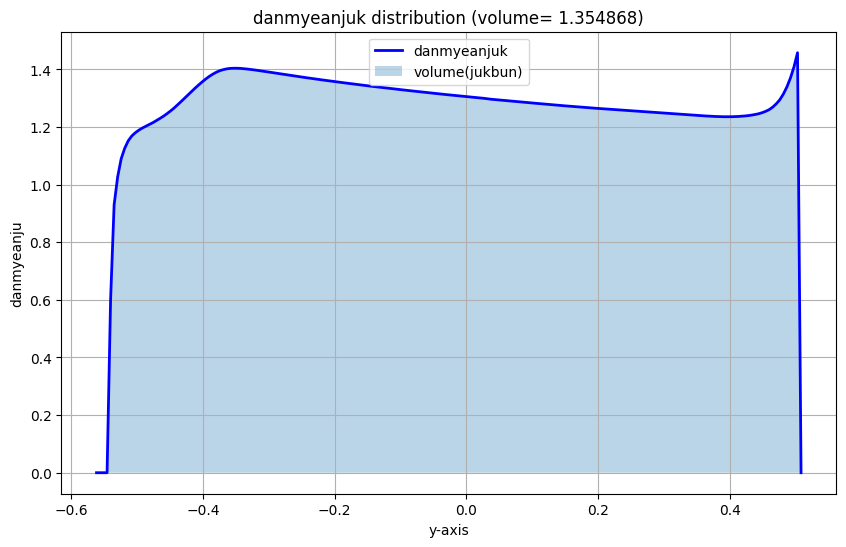

In [4]:
# 사용 예시
mesh = trimesh.load('pot.glb')

# 사다리꼴 공식 사용 (빠르고 간단)
volume, areas, y_coords = calculate_volume_by_cross_section(mesh, num_sections=200)


# 결과 시각화 (선택사항)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_coords, areas, 'b-', linewidth=2, label='danmyeanjuk')
plt.fill_between(y_coords, areas, alpha=0.3, label='volume(jukbun)')
plt.xlabel('y-axis')
plt.ylabel('danmyeanju')
plt.title(f'danmyeanjuk distribution (volume= {volume:.6f})')
plt.legend()
plt.grid(True)
plt.show()